In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal

In [2]:
class GatedTransition(nn.Module):
    def __init__(self, z_dim, hid_dim):
        super(GatedTransition, self).__init__()
        self.gate = nn.Sequential(nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, z_dim),
            nn.Sigmoid())
        self.proposed_mean = nn.Sequential(nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, z_dim))
        self.z_to_mu = nn.Linear(z_dim, z_dim)
        # modify the default initialization of z_to_mu
        # so that it starts out as the identity function
        self.z_to_mu.weight.data = torch.eye(z_dim)
        self.z_to_mu.bias.data = torch.zeros(z_dim)
        self.z_to_logvar = nn.Linear(z_dim, z_dim)
        self.relu = nn.ReLU()
        
    def forward(self, z_t_1):
        #
        gate = self.gate(z_t_1)
        proposed_mean = self.proposed_mean(z_t_1)
        mu = (1 - gate) * self.z_to_mu(z_t_1) + gate * proposed_mean
        logvar = self.z_to_logvar(self.relu(proposed_mean))
        # sampling
        eps = torch.randn(z_t_1.size())
        z_t = mu + eps * torch.exp(.5 * logvar)
        return z_t, mu, logvar

In [3]:
class Combiner(nn.Module):
    # PostNet
    def __init__(self, z_dim, hid_dim):
        super(Combiner, self).__init__()
        self.z_dim = z_dim
        self.z_to_hidden = nn.Linear(z_dim, hid_dim)
        self.hidden_to_mu = nn.Linear(hid_dim, z_dim)
        self.hidden_to_logvar = nn.Linear(hid_dim, z_dim)
        self.tanh = nn.Tanh()
    def forward(self, z_t_1, h_rnn):
        # combine the rnn hidden state with a transformed version of z_t_1
        h_combined = 0.5 * (self.tanh(self.z_to_hidden(z_t_1)) + h_rnn)
        # use the combined hidden state
        # to compute the mean used to sample z_t
        mu = self.hidden_to_mu(h_combined)
        # use the combined hidden state
        # to compute the scale used to sample z_t
        logvar = self.hidden_to_logvar(h_combined)
        eps = torch.randn(z_t_1.size())
        z_t = mu + eps * torch.exp(.5 * logvar)
        return z_t, mu, logvar

In [4]:
class Emitter(nn.Module):
    def __init__(self, z_dim, hid_dim, input_dim) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.z_to_hidden = nn.Linear(z_dim, hid_dim)
        self.hidden_to_hidden = nn.Linear(hid_dim, hid_dim)
        self.hidden_to_input_mu = nn.Linear(hid_dim, input_dim)
        self.logvar = nn.Parameter(torch.ones(input_dim))
        self.relu = nn.ReLU()
    def forward(self, z_t):
        h1 = self.relu(self.z_to_hidden(z_t))
        h2 = self.relu(self.hidden_to_hidden(h1))
        mu = self.hidden_to_input_mu(h2)
        # return mu # x_t
        eps = torch.randn(z_t.size(0), self.input_dim)
        x_t = mu + eps * torch.exp(.5 * self.logvar)
        return x_t, mu, self.logvar

In [5]:
class DKF(nn.Module):
    # Structured Inference Networks
    # Current version ignores backward RNN outputs
    def __init__(self, input_dim, z_dim=50, trans_dim=30, emission_dim=30,
            rnn_dim=100, num_rnn_layers=1) -> None:
        
        super().__init__()
        self.input_dim = input_dim
        self.z_dim = z_dim
        self.trans_dim = trans_dim
        self.emission_dim = emission_dim
        self.rnn_dim = rnn_dim
        self.num_rnn_layers = num_rnn_layers
        self.trans = GatedTransition(z_dim, trans_dim)
        self.emitter = Emitter(z_dim, emission_dim, input_dim)
        self.combiner = Combiner(z_dim, rnn_dim)
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))
        self.h_0 = nn.Parameter(torch.zeros(1, 1, rnn_dim))
        # corresponding learning 'l' in the original code
        self.rnn = nn.RNN(input_size=input_dim,
            hidden_size=rnn_dim,
            nonlinearity="relu",
            batch_first=True,
            bidirectional=False,
            num_layers=num_rnn_layers)
        
    def kl_div(self, mu1, logvar1, mu2=None, logvar2=None):
        if mu2 is None:
            mu2 = torch.zeros(1, device=mu1.device)
        if logvar2 is None:
            logvar2 = torch.zeros(1, device=mu1.device)
        return torch.sum(0.5 * (
            logvar2 - logvar1 + (torch.exp(logvar1) + (mu1 - mu2).pow(2))
            / torch.exp(logvar2) - torch.ones(1, device=mu1.device)
        ), 1)

    def infer(self, x):
        batch_size, T_max, x_dim = x.size()
        h_0 = self.h_0.expand(1, batch_size, self.rnn_dim).contiguous()
        rnn_out, h_n = self.rnn(x, h_0)
        z_prev = self.z_q_0.expand(batch_size, self.z_q_0.size(0))
        kl_states = torch.zeros((batch_size, T_max))
        rec_losses = torch.zeros((batch_size, T_max))
        for t in range(T_max):
            # p(z_t|z_{t-1})
            z_prior, z_prior_mu, z_prior_logvar = self.trans(z_prev)
            # q(z_t|z_{t-1},x_{t:T})
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            # p(x_t|z_t)
            x_t, x_mu, x_logvar = self.emitter(z_t)
            # compute loss
            kl_states[:, t] = self.kl_div(
                z_mu, z_logvar, z_prior_mu, z_prior_logvar)
            rec_losses[:, t] = nn.MSELoss(reduction='none')(
                x_t.contiguous().view(-1),
                # x_mu.contiguous().view(-1),
                x[:, t].contiguous().view(-1)
            ).view(batch_size, -1).mean(dim=1)
            z_prev = z_t
        return rec_losses.mean(), kl_states.mean()
    
    def filter(self, x, num_sample=100):
        # Outputs
        x_hat = torch.zeros(x.size())
        x_025 = torch.zeros(x.size())
        x_975 = torch.zeros(x.size())
        # predictions
        batch_size, T_max, x_dim = x.size()
        assert batch_size == 1
        z_prev = self.z_0.expand(num_sample, self.z_0.size(0))
        h_0 = self.h_0.expand(1, 1, self.rnn_dim).contiguous()
        rnn_out, _ = self.rnn(x, h_0)
        rnn_out = rnn_out.expand(num_sample,
            rnn_out.size(1), rnn_out.size(2))
        for t in range(T_max):
            # z_t: (num_sample, z_dim)
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            x_t, x_mu, x_logvar = self.emitter(z_t)
            # x_hat[:, t] = x_mu
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            # # sampling z_t and computing quantiles
            # x_samples = MultivariateNormal(
            #   loc=x_mu, covariance_matrix=x_covar).sample_n(num_sample)
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
            # x_hat[:, t] = x_t.mean(0)
            # x_025[:, t] = x_t.quantile(0.025, 0)
            # x_975[:, t] = x_t.quantile(0.975, 0)
            z_prev = z_t
            # z_prev = z_mu
        return x_hat, x_025, x_975
    
    def predict(self, x, pred_steps=1, num_sample=100):
        """ x should contain the prediction period
        """
        # Outputs
        x_hat = torch.zeros(x.size()) # predictions
        x_025 = torch.zeros(x.size())
        x_975 = torch.zeros(x.size())
        batch_size, T_max, x_dim = x.size()
        assert batch_size == 1
        z_prev = self.z_0.expand(num_sample, self.z_0.size(0))
        h_0 = self.h_0.expand(1, 1, self.rnn_dim).contiguous()
        rnn_out, _ = self.rnn(x[:, :T_max-pred_steps], h_0)
        rnn_out = rnn_out.expand(num_sample,
            rnn_out.size(1), rnn_out.size(2))
        for t in range(T_max - pred_steps):
            # z_t: (num_sample, z_dim)
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            x_t, x_mu, x_logvar = self.emitter(z_t)
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
            z_prev = z_mu
        for t in range(T_max - pred_steps, T_max):
            rnn_out, _ = self.rnn(x[:, :t], h_0)
            rnn_out = rnn_out.expand(
                num_sample, rnn_out.size(1), rnn_out.size(2))
            z_t_1, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, -1])
            z_t, z_mu, z_logvar = self.trans(z_t_1)
            x_t, x_mu, x_logvar = self.emitter(z_t)
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
        return x_hat, x_025, x_975
    
    def train_step(self, x, annealing_factor = 0.1):
        self.train()
        # self.rnn.train()
        rec_loss, kl_loss = self.infer(x)
        total_loss = rec_loss + annealing_factor * kl_loss
        self.optimizer.zero_grad()
        total_loss.backward()
        # nn.utils.clip_grad_norm_(self.parameters(), 5.)
        self.optimizer.step()
        return rec_loss.item(), kl_loss.item(), total_loss.item()
    
    def validation_step(self, x, annealing_factor=0.1):
        self.eval()
        rec_loss, kl_loss = self.infer(x)
        total_loss = rec_loss + annealing_factor * kl_loss
        return rec_loss.item(), kl_loss.item(), total_loss.item()
    
    def fit(self, x, x_val=None, num_epochs=100, annealing_factor=0.1,
            verbose_step=1, eval_step=1, check_point_path=None,
            patience=20, learning_rate=0.01):
        
        self.optimizer = torch.optim.Adam(
            self.parameters(), lr=learning_rate)
        
        losses = []
        kl_losses = []
        rec_losses = []
        val_losses = []
        val_kl_losses = []
        val_rec_losses = []
        
        for epoch in range(num_epochs):
            try:
                res = self.train_step(x, annealing_factor=annealing_factor)
                losses.append(res[2])
                kl_losses.append(res[1])
                rec_losses.append(res[0])  
                
                if epoch % verbose_step == verbose_step - 1:
                    message = f'Epoch= {epoch+1}/{num_epochs}, '
                    message += f'loss= {res[2]:.3f}, '
                    message += f'mse= {res[0]:.3f}, '
                    message += f'kld= {res[1]:.3f}'
                    print(message)    
                    
                if x_val is not None:
                    val_res = self.validation_step(x_val, annealing_factor)
                    val_losses.append(val_res[2])
                    val_kl_losses.append(val_res[1])
                    val_rec_losses.append(val_res[0])  
                    
                if epoch % eval_step == eval_step - 1 and x_val is not None:
                    message = f'\tval_loss= {val_res[2]:.3f}, '
                    message += f'val_mse= {val_res[0]:.3f}, '
                    message += f'val_kld= {val_res[1]:.3f}'
                    print(message)
                    
            except KeyboardInterrupt:
                break                    
                
        history = {'loss': losses,
                   'kl_loss': kl_losses,
                   'rec_loss': rec_losses}
        
        if x_val is not None:
            history.update({'val_loss': val_losses,
                            'val_kl_loss': val_kl_losses,
                            'rec_loss': rec_losses})
            
        return history
            
    def save_model(self, filename):
        """ dkf.pth """
        torch.save(self.to('cpu').state_dict(), filename)       
        
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        
    def get_config(self):
        return {
            'input_dim': self.input_dim,
            'z_dim': self.z_dim,
            'trans_dim': self.trans_dim,
            'emission_dim': self.emission_dim,
            'rnn_dim': self.rnn_dim,
            'num_rnn_layers': self.num_rnn_layers
        }

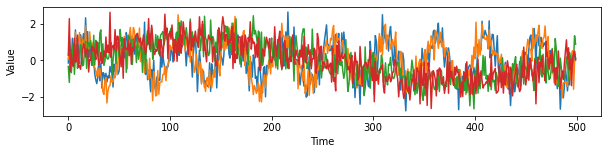

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import scale
# import warnings
# warnings.filterwarnings('ignore')
T = 500 # sequence length
observations = 2*np.sin(np.linspace(0, 20*np.pi, T))
interventions = 2*np.sin(np.linspace(0, 2*np.pi, T))
data = np.vstack([observations, observations*1.2, interventions,
  interventions*0.85]).T
data += np.random.randn(*data.shape)
# data[:, 2:] = preprocessing.minmax_scale(data[:, 2:])
data = scale(data)

plt.figure(figsize=(10, 2))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [7]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])

In [8]:
dkf = DKF(input_dim=4, z_dim=20, rnn_dim=20, trans_dim=20, emission_dim=20)

In [9]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 4.047, mse= 3.697, kld= 3.507
	val_loss= 3.692, val_mse= 3.428, val_kld= 2.634
Epoch= 2/200, loss= 4.333, mse= 4.069, kld= 2.638
	val_loss= 3.427, val_mse= 3.227, val_kld= 2.004
Epoch= 3/200, loss= 3.948, mse= 3.741, kld= 2.064
	val_loss= 3.706, val_mse= 3.541, val_kld= 1.655
Epoch= 4/200, loss= 4.022, mse= 3.855, kld= 1.664
	val_loss= 3.390, val_mse= 3.256, val_kld= 1.332
Epoch= 5/200, loss= 3.535, mse= 3.399, kld= 1.366
	val_loss= 3.692, val_mse= 3.582, val_kld= 1.105
Epoch= 6/200, loss= 3.657, mse= 3.543, kld= 1.144
	val_loss= 3.939, val_mse= 3.850, val_kld= 0.893
Epoch= 7/200, loss= 3.460, mse= 3.366, kld= 0.939
	val_loss= 3.645, val_mse= 3.569, val_kld= 0.763
Epoch= 8/200, loss= 3.555, mse= 3.476, kld= 0.792
	val_loss= 4.035, val_mse= 3.964, val_kld= 0.719
Epoch= 9/200, loss= 3.500, mse= 3.435, kld= 0.652
	val_loss= 3.635, val_mse= 3.582, val_kld= 0.534
Epoch= 10/200, loss= 3.549, mse= 3.491, kld= 0.579
	val_loss= 3.646, val_mse= 3.599, val_kld= 0.467
Epoch= 11

Epoch= 84/200, loss= 1.837, mse= 1.763, kld= 0.745
	val_loss= 1.739, val_mse= 1.658, val_kld= 0.817
Epoch= 85/200, loss= 1.841, mse= 1.756, kld= 0.850
	val_loss= 1.773, val_mse= 1.681, val_kld= 0.921
Epoch= 86/200, loss= 1.872, mse= 1.798, kld= 0.744
	val_loss= 2.031, val_mse= 1.955, val_kld= 0.766
Epoch= 87/200, loss= 1.771, mse= 1.684, kld= 0.869
	val_loss= 1.833, val_mse= 1.722, val_kld= 1.110
Epoch= 88/200, loss= 1.846, mse= 1.765, kld= 0.807
	val_loss= 1.850, val_mse= 1.754, val_kld= 0.954
Epoch= 89/200, loss= 1.908, mse= 1.822, kld= 0.867
	val_loss= 1.658, val_mse= 1.577, val_kld= 0.808
Epoch= 90/200, loss= 1.820, mse= 1.734, kld= 0.867
	val_loss= 1.623, val_mse= 1.519, val_kld= 1.047
Epoch= 91/200, loss= 1.797, mse= 1.713, kld= 0.844
	val_loss= 1.859, val_mse= 1.753, val_kld= 1.064
Epoch= 92/200, loss= 1.888, mse= 1.795, kld= 0.924
	val_loss= 1.629, val_mse= 1.516, val_kld= 1.139
Epoch= 93/200, loss= 1.759, mse= 1.666, kld= 0.927
	val_loss= 2.021, val_mse= 1.932, val_kld= 0.884


Epoch= 166/200, loss= 1.242, mse= 1.152, kld= 0.898
	val_loss= 1.221, val_mse= 1.129, val_kld= 0.918
Epoch= 167/200, loss= 1.156, mse= 1.062, kld= 0.938
	val_loss= 1.129, val_mse= 1.043, val_kld= 0.851
Epoch= 168/200, loss= 1.191, mse= 1.101, kld= 0.896
	val_loss= 1.009, val_mse= 0.920, val_kld= 0.882
Epoch= 169/200, loss= 1.250, mse= 1.162, kld= 0.882
	val_loss= 0.964, val_mse= 0.886, val_kld= 0.783
Epoch= 170/200, loss= 1.143, mse= 1.053, kld= 0.894
	val_loss= 1.212, val_mse= 1.140, val_kld= 0.714
Epoch= 171/200, loss= 1.258, mse= 1.170, kld= 0.872
	val_loss= 1.126, val_mse= 1.023, val_kld= 1.031
Epoch= 172/200, loss= 1.139, mse= 1.054, kld= 0.852
	val_loss= 1.071, val_mse= 0.996, val_kld= 0.751
Epoch= 173/200, loss= 1.164, mse= 1.074, kld= 0.892
	val_loss= 1.166, val_mse= 1.092, val_kld= 0.745
Epoch= 174/200, loss= 1.194, mse= 1.107, kld= 0.868
	val_loss= 1.044, val_mse= 0.977, val_kld= 0.671
Epoch= 175/200, loss= 1.175, mse= 1.090, kld= 0.852
	val_loss= 1.298, val_mse= 1.227, val_k

<AxesSubplot:xlabel='Epoch'>

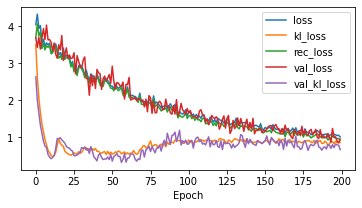

In [10]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

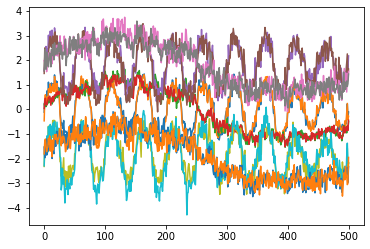

In [11]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

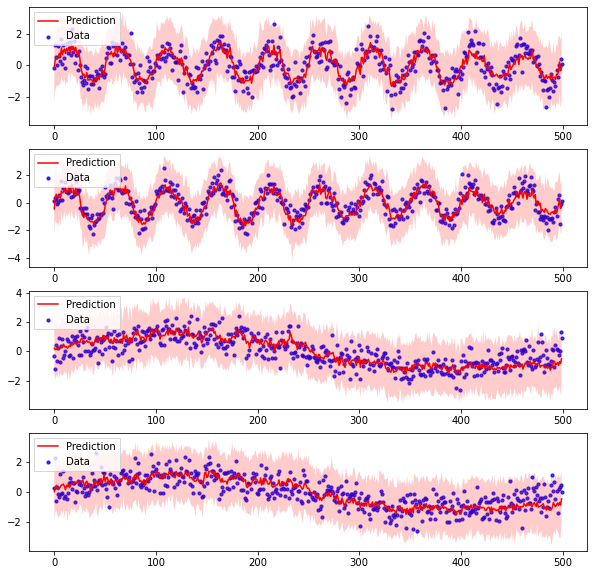

In [12]:
fig, ax = plt.subplots(4, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

TU SIĘ ZACZYNA MOJA PRACA

In [13]:
#wczytamy te dane

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import torch

In [15]:


#FIRST on 10 000 workouts - train 9000, test 1000
data_endo = []
i = 0
#with gzip.open('endomondoHR.json.gz') as f:

with open('endomondoHR_proper.json') as f:
    for l in f:
        i += 1
        print(i)
        data_endo.append(eval(l))
        if i == 10000:
            break
        #print(data[0])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127


3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806


5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453


6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105


8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745


dict_keys(['longitude', 'altitude', 'latitude', 'sport', 'id', 'heart_rate', 'gender', 'timestamp', 'url', 'userId', 'speed'])
0
[(0, 24.64977040886879), (1, 24.65014273300767), (2, 24.650910682976246), (3, 24.650668865069747), (4, 24.649145286530256), (5, 24.648349760100245), (6, 24.645312326028943), (7, 24.6447014529258), (8, 24.644415881484747), (9, 24.641415160149336), (10, 24.63826850987971), (11, 24.636211171746254), (12, 24.634060626849532), (13, 24.63249195367098), (14, 24.631360983476043), (15, 24.629418225958943), (16, 24.625693140551448), (17, 24.62388290092349), (18, 24.621391966938972), (19, 24.62025227956474), (20, 24.61888753809035), (21, 24.617006219923496), (22, 24.615299999713898), (23, 24.614676302298903), (24, 24.612943679094315), (25, 24.61235510185361), (26, 24.61154105141759), (27, 24.610843928530812), (28, 24.61042357608676), (29, 24.60953777655959), (30, 24.608315024524927), (31, 24.606816424056888), (32, 24.605027558282018), (33, 24.603541865944862), (34, 24.6

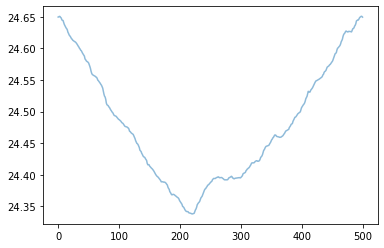

(500,)


In [16]:

# Plot ithmeasurement x longitude


print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
print(y.shape)

dict_keys(['longitude', 'altitude', 'latitude', 'sport', 'id', 'heart_rate', 'gender', 'timestamp', 'url', 'userId', 'speed'])
0
[(0, 24.64977040886879), (1, 24.65014273300767), (2, 24.650910682976246), (3, 24.650668865069747), (4, 24.649145286530256), (5, 24.648349760100245), (6, 24.645312326028943), (7, 24.6447014529258), (8, 24.644415881484747), (9, 24.641415160149336), (10, 24.63826850987971), (11, 24.636211171746254), (12, 24.634060626849532), (13, 24.63249195367098), (14, 24.631360983476043), (15, 24.629418225958943), (16, 24.625693140551448), (17, 24.62388290092349), (18, 24.621391966938972), (19, 24.62025227956474), (20, 24.61888753809035), (21, 24.617006219923496), (22, 24.615299999713898), (23, 24.614676302298903), (24, 24.612943679094315), (25, 24.61235510185361), (26, 24.61154105141759), (27, 24.610843928530812), (28, 24.61042357608676), (29, 24.60953777655959), (30, 24.608315024524927), (31, 24.606816424056888), (32, 24.605027558282018), (33, 24.603541865944862), (34, 24.6

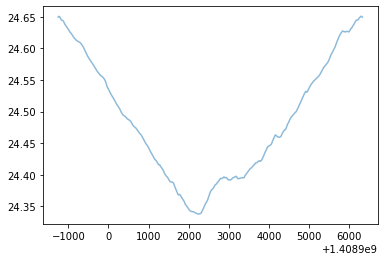

(500,)


In [17]:

# Plot timestamp x longitude


print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii



x = np.asarray(data_endo[0]['timestamp'])


plt.plot(x, y, alpha=0.5)
plt.show()
print(y.shape)


dict_keys(['longitude', 'altitude', 'latitude', 'sport', 'id', 'heart_rate', 'gender', 'timestamp', 'url', 'userId', 'speed'])
0
[(0, 60.173348765820265), (1, 60.173239801079035), (2, 60.17298021353781), (3, 60.172477969899774), (4, 60.17186114564538), (5, 60.17154498025775), (6, 60.1712366938591), (7, 60.1705339550972), (8, 60.169210117310286), (9, 60.168469324707985), (10, 60.1681249961257), (11, 60.1667985599488), (12, 60.1658867765218), (13, 60.165855176746845), (14, 60.16524790786207), (15, 60.16498521901667), (16, 60.16488212160766), (17, 60.16684088855982), (18, 60.168423894792795), (19, 60.16919804736972), (20, 60.169968931004405), (21, 60.17096495255828), (22, 60.17224084585905), (23, 60.1734712254256), (24, 60.17483823001385), (25, 60.17603072337806), (26, 60.17738071270287), (27, 60.17829819582403), (28, 60.17885944806039), (29, 60.18032728694379), (30, 60.18173536285758), (31, 60.18242904916406), (32, 60.183177553117275), (33, 60.18365657888353), (34, 60.18399721942842), (3

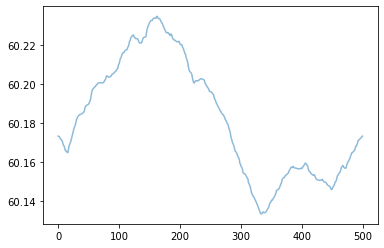

(500,)


In [18]:

# Plot ithmeasurement x latitude


print(data_endo[0].keys())
y=np.asarray(data_endo[0]['latitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
print(y.shape)

dict_keys(['longitude', 'altitude', 'latitude', 'sport', 'id', 'heart_rate', 'gender', 'timestamp', 'url', 'userId', 'speed'])
0
[(0, 60.173348765820265), (1, 60.173239801079035), (2, 60.17298021353781), (3, 60.172477969899774), (4, 60.17186114564538), (5, 60.17154498025775), (6, 60.1712366938591), (7, 60.1705339550972), (8, 60.169210117310286), (9, 60.168469324707985), (10, 60.1681249961257), (11, 60.1667985599488), (12, 60.1658867765218), (13, 60.165855176746845), (14, 60.16524790786207), (15, 60.16498521901667), (16, 60.16488212160766), (17, 60.16684088855982), (18, 60.168423894792795), (19, 60.16919804736972), (20, 60.169968931004405), (21, 60.17096495255828), (22, 60.17224084585905), (23, 60.1734712254256), (24, 60.17483823001385), (25, 60.17603072337806), (26, 60.17738071270287), (27, 60.17829819582403), (28, 60.17885944806039), (29, 60.18032728694379), (30, 60.18173536285758), (31, 60.18242904916406), (32, 60.183177553117275), (33, 60.18365657888353), (34, 60.18399721942842), (3

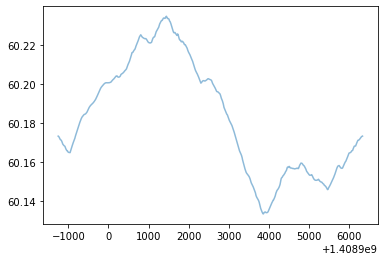

(500,)


In [19]:

# Plot timestamp x latitude


print(data_endo[0].keys())
y=np.asarray(data_endo[0]['latitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii



x = np.asarray(data_endo[0]['timestamp'])


plt.plot(x, y, alpha=0.5)
plt.show()
print(y.shape)


dict_keys(['longitude', 'altitude', 'latitude', 'sport', 'id', 'heart_rate', 'gender', 'timestamp', 'url', 'userId', 'speed'])
0
[(0, 41.6), (1, 40.6), (2, 40.6), (3, 38.4), (4, 37.0), (5, 34.0), (6, 34.0), (7, 34.0), (8, 34.0), (9, 34.0), (10, 34.0), (11, 34.0), (12, 34.0), (13, 34.0), (14, 34.0), (15, 34.0), (16, 34.0), (17, 34.0), (18, 33.2), (19, 31.6), (20, 29.8), (21, 29.8), (22, 29.8), (23, 29.8), (24, 29.8), (25, 29.8), (26, 29.8), (27, 32.0), (28, 34.2), (29, 34.2), (30, 33.8), (31, 32.2), (32, 34.4), (33, 37.0), (34, 38.6), (35, 36.6), (36, 34.4), (37, 32.6), (38, 29.8), (39, 27.8), (40, 26.2), (41, 23.6), (42, 22.0), (43, 21.6), (44, 21.6), (45, 21.6), (46, 22.0), (47, 24.4), (48, 27.0), (49, 27.8), (50, 30.0), (51, 30.0), (52, 30.0), (53, 30.0), (54, 30.0), (55, 30.0), (56, 30.8), (57, 33.2), (58, 35.6), (59, 38.2), (60, 40.2), (61, 42.2), (62, 44.4), (63, 46.4), (64, 48.2), (65, 48.6), (66, 46.6), (67, 43.6), (68, 41.4), (69, 37.8), (70, 34.0), (71, 31.4), (72, 28.8), (73,

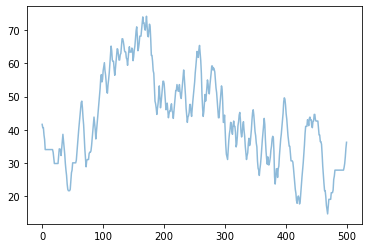

(500,)


In [20]:

# Plot ithmeasurement x altitude

print(data_endo[0].keys())
y=np.asarray(data_endo[0]['altitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
print(y.shape)

dict_keys(['longitude', 'altitude', 'latitude', 'sport', 'id', 'heart_rate', 'gender', 'timestamp', 'url', 'userId', 'speed'])
0
[(0, 41.6), (1, 40.6), (2, 40.6), (3, 38.4), (4, 37.0), (5, 34.0), (6, 34.0), (7, 34.0), (8, 34.0), (9, 34.0), (10, 34.0), (11, 34.0), (12, 34.0), (13, 34.0), (14, 34.0), (15, 34.0), (16, 34.0), (17, 34.0), (18, 33.2), (19, 31.6), (20, 29.8), (21, 29.8), (22, 29.8), (23, 29.8), (24, 29.8), (25, 29.8), (26, 29.8), (27, 32.0), (28, 34.2), (29, 34.2), (30, 33.8), (31, 32.2), (32, 34.4), (33, 37.0), (34, 38.6), (35, 36.6), (36, 34.4), (37, 32.6), (38, 29.8), (39, 27.8), (40, 26.2), (41, 23.6), (42, 22.0), (43, 21.6), (44, 21.6), (45, 21.6), (46, 22.0), (47, 24.4), (48, 27.0), (49, 27.8), (50, 30.0), (51, 30.0), (52, 30.0), (53, 30.0), (54, 30.0), (55, 30.0), (56, 30.8), (57, 33.2), (58, 35.6), (59, 38.2), (60, 40.2), (61, 42.2), (62, 44.4), (63, 46.4), (64, 48.2), (65, 48.6), (66, 46.6), (67, 43.6), (68, 41.4), (69, 37.8), (70, 34.0), (71, 31.4), (72, 28.8), (73,

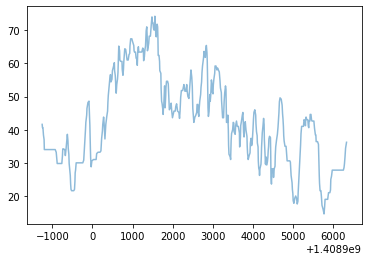

(500,)


In [21]:

# Plot timestamp x altitude


print(data_endo[0].keys())
y=np.asarray(data_endo[0]['altitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii



x = np.asarray(data_endo[0]['timestamp'])


plt.plot(x, y, alpha=0.5)
plt.show()
print(y.shape)

In [22]:
####OK wykresy sie zgadzaja

In [23]:
###TERAZ TRENUJEMY DLA 1 WORKOUTU LONGITUDE,TRAIN TO PIERWSZE 450 A VAL TO KOLEJNE 50

In [24]:
#### ITHMEASUREMENT vs LONGITUDE

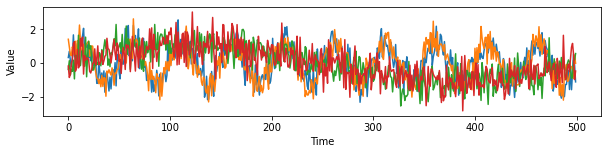

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import scale
# import warnings
# warnings.filterwarnings('ignore')
T = 500 # sequence length
observations = 2*np.sin(np.linspace(0, 20*np.pi, T))
interventions = 2*np.sin(np.linspace(0, 2*np.pi, T))
data = np.vstack([observations, observations*1.2, interventions,
  interventions*0.85]).T
data += np.random.randn(*data.shape)
# data[:, 2:] = preprocessing.minmax_scale(data[:, 2:])
data = scale(data)

plt.figure(figsize=(10, 2))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [26]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
print(x_train)
x_val = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
print(x_val)
print(data.shape[1])

tensor([[[ 0.3442,  1.4190, -0.3613, -0.1611],
         [ 0.7120,  0.9848,  0.1525, -0.8367],
         [ 0.1533,  0.5280, -0.6945, -0.6438],
         ...,
         [ 0.5414, -0.8951,  0.1735,  0.5171],
         [-0.0846,  0.4757,  0.2032, -0.9618],
         [-1.0956,  0.0044,  0.5746, -0.4576]]])
tensor([[[ 0.3442,  1.4190, -0.3613, -0.1611],
         [ 0.7120,  0.9848,  0.1525, -0.8367],
         [ 0.1533,  0.5280, -0.6945, -0.6438],
         ...,
         [ 0.3431, -1.5652, -0.8331, -0.4908],
         [-0.2277,  0.0359, -0.5124, -0.5061],
         [ 0.2565, -1.2008, -1.0894, -1.8992]]])
tensor([[[ 1.2777e-01,  8.8834e-01, -8.7513e-01, -5.2414e-01],
         [ 6.6099e-01, -2.6180e-01, -6.4116e-01,  2.2168e-02],
         [ 6.7071e-05,  9.2271e-01, -1.5050e+00, -1.2906e+00],
         [ 4.8172e-02,  5.3722e-02, -9.8105e-01, -7.7992e-02],
         [ 9.3881e-01,  1.1232e+00, -5.8501e-01, -1.8801e+00],
         [ 2.3443e-01,  6.4428e-01, -9.2767e-01, -1.1263e+00],
         [ 6.0057e-01,  2.

dict_keys(['longitude', 'altitude', 'latitude', 'sport', 'id', 'heart_rate', 'gender', 'timestamp', 'url', 'userId', 'speed'])
0
[(0, 24.64977040886879), (1, 24.65014273300767), (2, 24.650910682976246), (3, 24.650668865069747), (4, 24.649145286530256), (5, 24.648349760100245), (6, 24.645312326028943), (7, 24.6447014529258), (8, 24.644415881484747), (9, 24.641415160149336), (10, 24.63826850987971), (11, 24.636211171746254), (12, 24.634060626849532), (13, 24.63249195367098), (14, 24.631360983476043), (15, 24.629418225958943), (16, 24.625693140551448), (17, 24.62388290092349), (18, 24.621391966938972), (19, 24.62025227956474), (20, 24.61888753809035), (21, 24.617006219923496), (22, 24.615299999713898), (23, 24.614676302298903), (24, 24.612943679094315), (25, 24.61235510185361), (26, 24.61154105141759), (27, 24.610843928530812), (28, 24.61042357608676), (29, 24.60953777655959), (30, 24.608315024524927), (31, 24.606816424056888), (32, 24.605027558282018), (33, 24.603541865944862), (34, 24.6

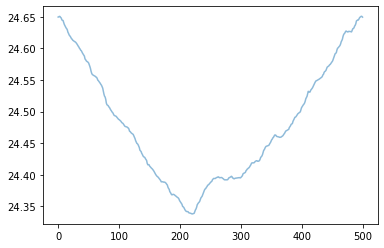

(500,)


In [27]:

# Plot ithmeasurement x longitude



print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
print(y.shape)

In [28]:
#x = torch.FloatTensor(data).reshape(1, *data.shape)
#x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])

y_data = torch.FloatTensor(y).reshape(1, 500, 1)
print(y_data)
y_train = torch.FloatTensor(y[:450]).reshape(1, 450, 1)
print(y_train)
y_val = torch.FloatTensor(y[450:500]).reshape(1, 50, 1)
print(y_val)


tensor([[[24.6498],
         [24.6501],
         [24.6509],
         [24.6507],
         [24.6491],
         [24.6483],
         [24.6453],
         [24.6447],
         [24.6444],
         [24.6414],
         [24.6383],
         [24.6362],
         [24.6341],
         [24.6325],
         [24.6314],
         [24.6294],
         [24.6257],
         [24.6239],
         [24.6214],
         [24.6203],
         [24.6189],
         [24.6170],
         [24.6153],
         [24.6147],
         [24.6129],
         [24.6124],
         [24.6115],
         [24.6108],
         [24.6104],
         [24.6095],
         [24.6083],
         [24.6068],
         [24.6050],
         [24.6035],
         [24.6022],
         [24.6002],
         [24.5991],
         [24.5971],
         [24.5964],
         [24.5942],
         [24.5925],
         [24.5910],
         [24.5898],
         [24.5879],
         [24.5835],
         [24.5823],
         [24.5805],
         [24.5795],
         [24.5790],
         [24.5781],


In [29]:
dkf = DKF(input_dim=1, z_dim=5, rnn_dim=5, trans_dim=5, emission_dim=5)

In [30]:
history = dkf.fit(y_train, y_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 596.216, mse= 595.491, kld= 7.248
	val_loss= 581.690, val_mse= 581.249, val_kld= 4.407
Epoch= 2/200, loss= 591.542, mse= 591.096, kld= 4.459
	val_loss= 587.388, val_mse= 587.061, val_kld= 3.277
Epoch= 3/200, loss= 587.227, mse= 586.909, kld= 3.175
	val_loss= 590.943, val_mse= 590.687, val_kld= 2.563
Epoch= 4/200, loss= 582.654, mse= 582.410, kld= 2.442
	val_loss= 616.593, val_mse= 616.382, val_kld= 2.109
Epoch= 5/200, loss= 586.211, mse= 585.995, kld= 2.165
	val_loss= 582.803, val_mse= 582.594, val_kld= 2.095
Epoch= 6/200, loss= 584.994, mse= 584.811, kld= 1.829
	val_loss= 595.269, val_mse= 595.087, val_kld= 1.821
Epoch= 7/200, loss= 589.207, mse= 589.040, kld= 1.666
	val_loss= 583.927, val_mse= 583.758, val_kld= 1.690
Epoch= 8/200, loss= 580.940, mse= 580.781, kld= 1.592
	val_loss= 586.841, val_mse= 586.658, val_kld= 1.831
Epoch= 9/200, loss= 582.310, mse= 582.157, kld= 1.529
	val_loss= 579.178, val_mse= 579.008, val_kld= 1.702
Epoch= 10/200, loss= 579.476, mse= 57

Epoch= 77/200, loss= 553.495, mse= 553.474, kld= 0.210
	val_loss= 560.450, val_mse= 560.423, val_kld= 0.266
Epoch= 78/200, loss= 548.480, mse= 548.461, kld= 0.192
	val_loss= 549.621, val_mse= 549.595, val_kld= 0.261
Epoch= 79/200, loss= 554.205, mse= 554.185, kld= 0.202
	val_loss= 548.089, val_mse= 548.062, val_kld= 0.268
Epoch= 80/200, loss= 546.270, mse= 546.252, kld= 0.187
	val_loss= 566.768, val_mse= 566.744, val_kld= 0.238
Epoch= 81/200, loss= 549.737, mse= 549.717, kld= 0.192
	val_loss= 566.932, val_mse= 566.909, val_kld= 0.231
Epoch= 82/200, loss= 546.519, mse= 546.502, kld= 0.167
	val_loss= 558.919, val_mse= 558.901, val_kld= 0.180
Epoch= 83/200, loss= 546.629, mse= 546.612, kld= 0.165
	val_loss= 553.768, val_mse= 553.746, val_kld= 0.215
Epoch= 84/200, loss= 548.693, mse= 548.678, kld= 0.150
	val_loss= 550.196, val_mse= 550.177, val_kld= 0.184
Epoch= 85/200, loss= 544.770, mse= 544.754, kld= 0.155
	val_loss= 551.828, val_mse= 551.813, val_kld= 0.148
Epoch= 86/200, loss= 542.406

Epoch= 153/200, loss= 513.863, mse= 513.861, kld= 0.022
	val_loss= 522.076, val_mse= 522.073, val_kld= 0.030
Epoch= 154/200, loss= 514.311, mse= 514.308, kld= 0.027
	val_loss= 515.312, val_mse= 515.310, val_kld= 0.018
Epoch= 155/200, loss= 516.052, mse= 516.050, kld= 0.020
	val_loss= 525.654, val_mse= 525.652, val_kld= 0.020
Epoch= 156/200, loss= 511.194, mse= 511.192, kld= 0.026
	val_loss= 529.029, val_mse= 529.027, val_kld= 0.025
Epoch= 157/200, loss= 513.798, mse= 513.795, kld= 0.031
	val_loss= 522.783, val_mse= 522.779, val_kld= 0.038
Epoch= 158/200, loss= 513.661, mse= 513.658, kld= 0.023
	val_loss= 506.652, val_mse= 506.650, val_kld= 0.019
Epoch= 159/200, loss= 511.644, mse= 511.642, kld= 0.025
	val_loss= 522.579, val_mse= 522.577, val_kld= 0.020
Epoch= 160/200, loss= 513.934, mse= 513.932, kld= 0.022
	val_loss= 517.605, val_mse= 517.603, val_kld= 0.022
Epoch= 161/200, loss= 513.644, mse= 513.642, kld= 0.022
	val_loss= 502.436, val_mse= 502.434, val_kld= 0.021
Epoch= 162/200, los

<AxesSubplot:xlabel='Epoch'>

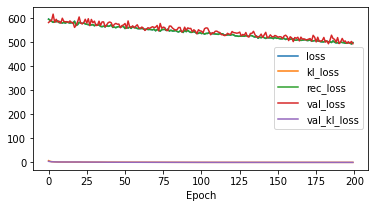

In [31]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

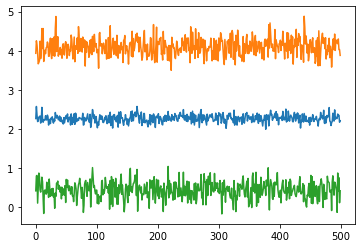

In [32]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(y_data, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

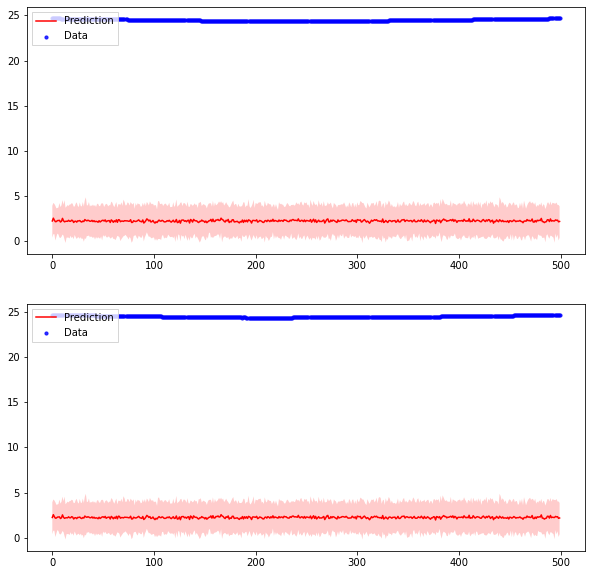

In [33]:
fig, ax = plt.subplots(2, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(y.shape[0]),
        y[:], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, 0], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, 0], x_975[:, 0],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [34]:
###################################################################################################################

In [35]:
####################################################################################################################

In [36]:
#DOBRA TUTAJ TRENUJEMY DKF'a dla 1szego WORKOUTU 3 na RAZ LON LAT ALT

dict_keys(['longitude', 'altitude', 'latitude', 'sport', 'id', 'heart_rate', 'gender', 'timestamp', 'url', 'userId', 'speed'])
0
[(0, 24.64977040886879), (1, 24.65014273300767), (2, 24.650910682976246), (3, 24.650668865069747), (4, 24.649145286530256), (5, 24.648349760100245), (6, 24.645312326028943), (7, 24.6447014529258), (8, 24.644415881484747), (9, 24.641415160149336), (10, 24.63826850987971), (11, 24.636211171746254), (12, 24.634060626849532), (13, 24.63249195367098), (14, 24.631360983476043), (15, 24.629418225958943), (16, 24.625693140551448), (17, 24.62388290092349), (18, 24.621391966938972), (19, 24.62025227956474), (20, 24.61888753809035), (21, 24.617006219923496), (22, 24.615299999713898), (23, 24.614676302298903), (24, 24.612943679094315), (25, 24.61235510185361), (26, 24.61154105141759), (27, 24.610843928530812), (28, 24.61042357608676), (29, 24.60953777655959), (30, 24.608315024524927), (31, 24.606816424056888), (32, 24.605027558282018), (33, 24.603541865944862), (34, 24.6

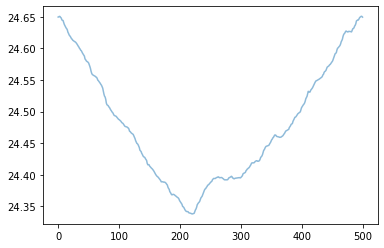

(500,)
(500, 3)


In [37]:

# Plot ithmeasurement x longitude


print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
print(y.shape)





first_workout_data = np.vstack([np.asarray(data_endo[0]['longitude']), np.asarray(data_endo[0]['latitude']), np.asarray(data_endo[0]['altitude'])]).T
print(first_workout_data.shape)

In [38]:
x = torch.FloatTensor(first_workout_data).reshape(1, *first_workout_data.shape)
print(x)
x_train = torch.FloatTensor(first_workout_data[:450]).reshape(1, 450, first_workout_data.shape[1])
print(x_train)
x_val   = torch.FloatTensor(first_workout_data[450:500]).reshape(1, 50, first_workout_data.shape[1])
print(x_val)

tensor([[[24.6498, 60.1733, 41.6000],
         [24.6501, 60.1732, 40.6000],
         [24.6509, 60.1730, 40.6000],
         ...,
         [24.6511, 60.1726, 31.8000],
         [24.6507, 60.1731, 34.4000],
         [24.6497, 60.1734, 36.2000]]])
tensor([[[24.6498, 60.1733, 41.6000],
         [24.6501, 60.1732, 40.6000],
         [24.6509, 60.1730, 40.6000],
         ...,
         [24.5761, 60.1464, 44.6000],
         [24.5773, 60.1459, 43.0000],
         [24.5787, 60.1460, 42.6000]]])
tensor([[[24.5804, 60.1469, 42.6000],
         [24.5831, 60.1474, 42.6000],
         [24.5855, 60.1480, 42.6000],
         [24.5882, 60.1487, 40.4000],
         [24.5915, 60.1497, 38.4000],
         [24.5924, 60.1501, 38.4000],
         [24.5933, 60.1505, 36.4000],
         [24.5974, 60.1520, 36.4000],
         [24.6003, 60.1531, 35.6000],
         [24.6011, 60.1535, 32.6000],
         [24.6022, 60.1540, 29.0000],
         [24.6033, 60.1544, 26.2000],
         [24.6047, 60.1548, 23.8000],
         [24.6071,

In [39]:
dkf = DKF(input_dim=3, z_dim=15, rnn_dim=15, trans_dim=15, emission_dim=15)

In [40]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 2190.182, mse= 2134.245, kld= 559.374
	val_loss= 1666.990, val_mse= 1661.607, val_kld= 53.831
Epoch= 2/200, loss= 2137.879, mse= 2129.980, kld= 78.984
	val_loss= 1673.900, val_mse= 1671.049, val_kld= 28.511
Epoch= 3/200, loss= 2120.767, mse= 2116.738, kld= 40.285
	val_loss= 1640.163, val_mse= 1638.030, val_kld= 21.332
Epoch= 4/200, loss= 2104.162, mse= 2101.357, kld= 28.050
	val_loss= 1657.149, val_mse= 1655.328, val_kld= 18.202
Epoch= 5/200, loss= 2088.806, mse= 2086.495, kld= 23.108
	val_loss= 1626.908, val_mse= 1625.201, val_kld= 17.071
Epoch= 6/200, loss= 2064.412, mse= 2062.358, kld= 20.535
	val_loss= 1591.124, val_mse= 1589.482, val_kld= 16.421
Epoch= 7/200, loss= 2019.960, mse= 2017.990, kld= 19.701
	val_loss= 1533.795, val_mse= 1532.117, val_kld= 16.781
Epoch= 8/200, loss= 1969.237, mse= 1967.248, kld= 19.887
	val_loss= 1472.497, val_mse= 1470.865, val_kld= 16.320
Epoch= 9/200, loss= 1888.539, mse= 1886.383, kld= 21.565
	val_loss= 1351.053, val_mse= 1349.179

Epoch= 77/200, loss= 40.870, mse= 39.929, kld= 9.416
	val_loss= 93.471, val_mse= 91.649, val_kld= 18.223
Epoch= 78/200, loss= 39.465, mse= 38.525, kld= 9.400
	val_loss= 94.607, val_mse= 92.775, val_kld= 18.319
Epoch= 79/200, loss= 40.537, mse= 39.600, kld= 9.370
	val_loss= 86.450, val_mse= 84.635, val_kld= 18.150
Epoch= 80/200, loss= 40.851, mse= 39.914, kld= 9.363
	val_loss= 92.453, val_mse= 90.638, val_kld= 18.146
Epoch= 81/200, loss= 39.826, mse= 38.901, kld= 9.251
	val_loss= 86.401, val_mse= 84.597, val_kld= 18.043
Epoch= 82/200, loss= 40.790, mse= 39.859, kld= 9.308
	val_loss= 88.265, val_mse= 86.453, val_kld= 18.119
Epoch= 83/200, loss= 40.331, mse= 39.411, kld= 9.199
	val_loss= 84.980, val_mse= 83.205, val_kld= 17.750
Epoch= 84/200, loss= 40.496, mse= 39.591, kld= 9.044
	val_loss= 86.332, val_mse= 84.553, val_kld= 17.791
Epoch= 85/200, loss= 40.043, mse= 39.148, kld= 8.947
	val_loss= 84.257, val_mse= 82.469, val_kld= 17.878
Epoch= 86/200, loss= 40.735, mse= 39.839, kld= 8.957
	v

Epoch= 155/200, loss= 39.236, mse= 38.630, kld= 6.052
	val_loss= 84.319, val_mse= 83.008, val_kld= 13.106
Epoch= 156/200, loss= 38.567, mse= 37.961, kld= 6.064
	val_loss= 87.889, val_mse= 86.594, val_kld= 12.943
Epoch= 157/200, loss= 38.913, mse= 38.312, kld= 6.005
	val_loss= 89.679, val_mse= 88.425, val_kld= 12.545
Epoch= 158/200, loss= 38.673, mse= 38.068, kld= 6.043
	val_loss= 90.041, val_mse= 88.798, val_kld= 12.432
Epoch= 159/200, loss= 38.829, mse= 38.232, kld= 5.964
	val_loss= 90.897, val_mse= 89.668, val_kld= 12.291
Epoch= 160/200, loss= 39.215, mse= 38.623, kld= 5.926
	val_loss= 89.869, val_mse= 88.653, val_kld= 12.167
Epoch= 161/200, loss= 38.761, mse= 38.172, kld= 5.883
	val_loss= 86.967, val_mse= 85.788, val_kld= 11.796
Epoch= 162/200, loss= 38.407, mse= 37.820, kld= 5.873
	val_loss= 86.593, val_mse= 85.442, val_kld= 11.509
Epoch= 163/200, loss= 38.971, mse= 38.387, kld= 5.842
	val_loss= 85.987, val_mse= 84.876, val_kld= 11.106
Epoch= 164/200, loss= 39.180, mse= 38.609, kld

<AxesSubplot:xlabel='Epoch'>

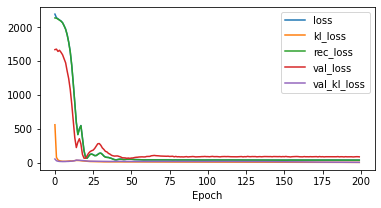

In [41]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

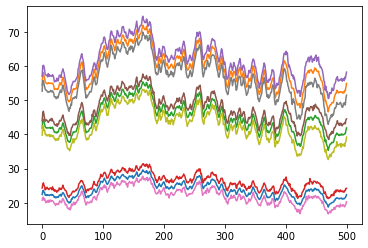

In [42]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

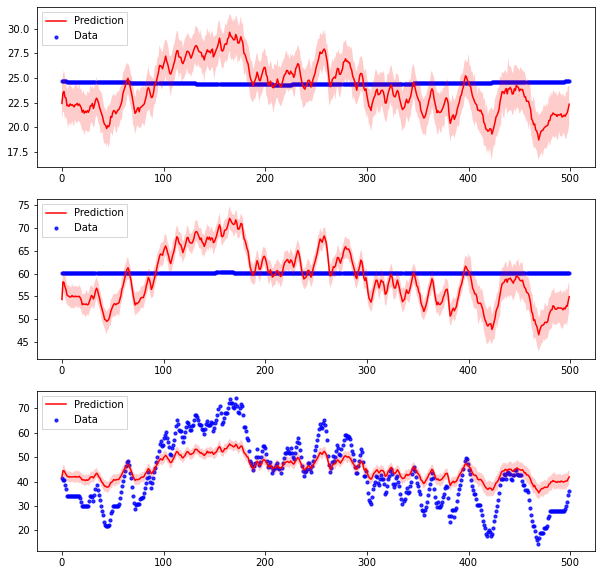

In [43]:
fig, ax = plt.subplots(3, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(first_workout_data.shape[0]),
        first_workout_data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [44]:
###################################################################################################################

In [45]:
####################################################################################################################

In [46]:
#TERAZ DKF DLA LONGITUDE DLA 3 PIERWSZYCH WORKOUTOW

In [47]:
longitude_three_data = np.vstack([np.asarray(data_endo[0]['longitude']), np.asarray(data_endo[1]['longitude']), np.asarray(data_endo[2]['longitude'])]).T
print(first_workout_data.shape)

(500, 3)


In [48]:
x = torch.FloatTensor(longitude_three_data).reshape(1, *longitude_three_data.shape)
print(x)
x_train = torch.FloatTensor(longitude_three_data[:450]).reshape(1, 450, longitude_three_data.shape[1])
print(x_train)
x_val   = torch.FloatTensor(longitude_three_data[450:500]).reshape(1, 50, longitude_three_data.shape[1])
print(x_val)

tensor([[[24.6498, 24.6499, 24.6500],
         [24.6501, 24.6502, 24.6502],
         [24.6509, 24.6509, 24.6511],
         ...,
         [24.6511, 24.6508, 24.6511],
         [24.6507, 24.6507, 24.6508],
         [24.6497, 24.6497, 24.6497]]])
tensor([[[24.6498, 24.6499, 24.6500],
         [24.6501, 24.6502, 24.6502],
         [24.6509, 24.6509, 24.6511],
         ...,
         [24.5761, 24.6107, 24.5954],
         [24.5773, 24.6118, 24.5986],
         [24.5787, 24.6125, 24.6000]]])
tensor([[[24.5804, 24.6127, 24.6009],
         [24.5831, 24.6129, 24.6013],
         [24.5855, 24.6133, 24.6021],
         [24.5882, 24.6143, 24.6034],
         [24.5915, 24.6145, 24.6042],
         [24.5924, 24.6148, 24.6058],
         [24.5933, 24.6155, 24.6080],
         [24.5974, 24.6162, 24.6095],
         [24.6003, 24.6169, 24.6126],
         [24.6011, 24.6172, 24.6144],
         [24.6022, 24.6176, 24.6173],
         [24.6033, 24.6192, 24.6190],
         [24.6047, 24.6200, 24.6216],
         [24.6071,

In [49]:
dkf = DKF(input_dim=3, z_dim=15, rnn_dim=15, trans_dim=15, emission_dim=15)

In [50]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 594.201, mse= 592.454, kld= 17.465
	val_loss= 606.838, val_mse= 605.966, val_kld= 8.723
Epoch= 2/200, loss= 588.704, mse= 587.922, kld= 7.818
	val_loss= 581.418, val_mse= 580.740, val_kld= 6.785
Epoch= 3/200, loss= 583.910, mse= 583.227, kld= 6.835
	val_loss= 584.318, val_mse= 583.436, val_kld= 8.823
Epoch= 4/200, loss= 570.098, mse= 569.295, kld= 8.021
	val_loss= 556.499, val_mse= 555.325, val_kld= 11.743
Epoch= 5/200, loss= 547.622, mse= 546.556, kld= 10.669
	val_loss= 522.267, val_mse= 520.748, val_kld= 15.185
Epoch= 6/200, loss= 508.912, mse= 507.481, kld= 14.313
	val_loss= 453.721, val_mse= 451.526, val_kld= 21.952
Epoch= 7/200, loss= 447.695, mse= 445.568, kld= 21.268
	val_loss= 361.938, val_mse= 359.146, val_kld= 27.916
Epoch= 8/200, loss= 356.503, mse= 353.884, kld= 26.188
	val_loss= 256.501, val_mse= 253.291, val_kld= 32.102
Epoch= 9/200, loss= 236.120, mse= 233.077, kld= 30.433
	val_loss= 117.613, val_mse= 113.119, val_kld= 44.943
Epoch= 10/200, loss= 111.

Epoch= 81/200, loss= 1.967, mse= 1.650, kld= 3.161
	val_loss= 2.420, val_mse= 1.660, val_kld= 7.600
Epoch= 82/200, loss= 1.991, mse= 1.677, kld= 3.136
	val_loss= 2.345, val_mse= 1.592, val_kld= 7.529
Epoch= 83/200, loss= 1.967, mse= 1.660, kld= 3.071
	val_loss= 2.563, val_mse= 1.796, val_kld= 7.679
Epoch= 84/200, loss= 1.922, mse= 1.620, kld= 3.024
	val_loss= 2.549, val_mse= 1.789, val_kld= 7.597
Epoch= 85/200, loss= 1.949, mse= 1.652, kld= 2.968
	val_loss= 2.244, val_mse= 1.504, val_kld= 7.394
Epoch= 86/200, loss= 1.913, mse= 1.617, kld= 2.960
	val_loss= 2.560, val_mse= 1.804, val_kld= 7.551
Epoch= 87/200, loss= 1.752, mse= 1.462, kld= 2.892
	val_loss= 2.422, val_mse= 1.685, val_kld= 7.368
Epoch= 88/200, loss= 1.764, mse= 1.472, kld= 2.920
	val_loss= 2.252, val_mse= 1.500, val_kld= 7.526
Epoch= 89/200, loss= 1.817, mse= 1.522, kld= 2.955
	val_loss= 1.888, val_mse= 1.150, val_kld= 7.375
Epoch= 90/200, loss= 1.845, mse= 1.560, kld= 2.848
	val_loss= 2.209, val_mse= 1.502, val_kld= 7.070


Epoch= 163/200, loss= 1.008, mse= 0.856, kld= 1.519
	val_loss= 1.146, val_mse= 0.917, val_kld= 2.289
Epoch= 164/200, loss= 1.068, mse= 0.919, kld= 1.497
	val_loss= 1.137, val_mse= 0.882, val_kld= 2.549
Epoch= 165/200, loss= 1.079, mse= 0.914, kld= 1.646
	val_loss= 1.340, val_mse= 1.128, val_kld= 2.127
Epoch= 166/200, loss= 1.036, mse= 0.902, kld= 1.338
	val_loss= 1.110, val_mse= 0.898, val_kld= 2.120
Epoch= 167/200, loss= 1.042, mse= 0.888, kld= 1.537
	val_loss= 0.866, val_mse= 0.638, val_kld= 2.285
Epoch= 168/200, loss= 1.005, mse= 0.851, kld= 1.541
	val_loss= 1.087, val_mse= 0.886, val_kld= 2.007
Epoch= 169/200, loss= 0.951, mse= 0.827, kld= 1.235
	val_loss= 1.033, val_mse= 0.798, val_kld= 2.350
Epoch= 170/200, loss= 1.059, mse= 0.906, kld= 1.528
	val_loss= 1.261, val_mse= 1.042, val_kld= 2.183
Epoch= 171/200, loss= 1.052, mse= 0.914, kld= 1.383
	val_loss= 1.096, val_mse= 0.869, val_kld= 2.277
Epoch= 172/200, loss= 0.983, mse= 0.853, kld= 1.306
	val_loss= 0.918, val_mse= 0.698, val_k

<AxesSubplot:xlabel='Epoch'>

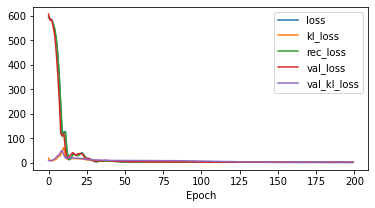

In [51]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

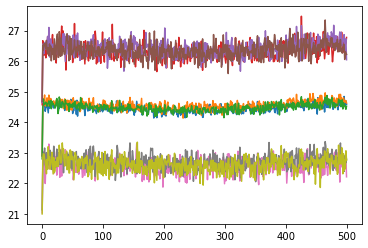

In [52]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

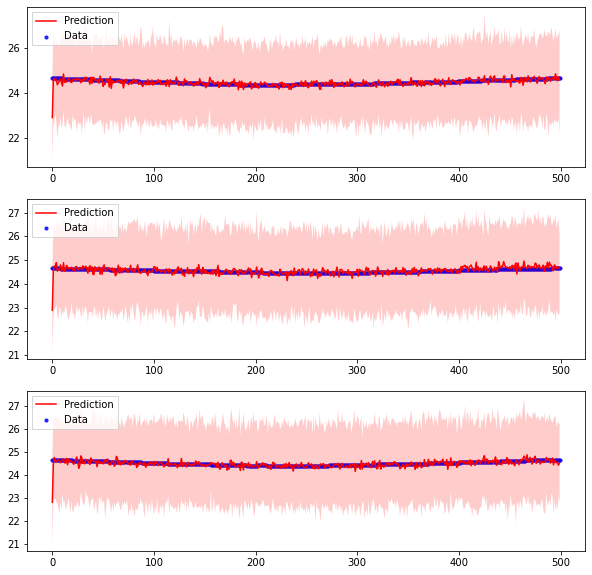

In [53]:
fig, ax = plt.subplots(3, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(longitude_three_data.shape[0]),
        longitude_three_data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [54]:
####################################################################################################################

In [55]:
####################################################################################################################

In [56]:
#TUTAJ DKF PO ALTITUDE DLA 5 WORKOUTOW

In [57]:
data = np.vstack([np.asarray(data_endo[0]['altitude']), np.asarray(data_endo[1]['altitude']), 
                  np.asarray(data_endo[2]['altitude']), np.asarray(data_endo[3]['altitude']),
                  np.asarray(data_endo[4]['altitude'])]).T
print(data.shape)

(500, 5)


In [58]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
print(x)
x_train = torch.FloatTensor(data[:450]).reshape(1, 450, data.shape[1])
print(x_train)
x_val   = torch.FloatTensor(data[450:500]).reshape(1, 50, data.shape[1])
print(x_val)

tensor([[[41.6000, 38.4000, 76.4000, 28.6000, 32.0000],
         [40.6000, 39.0000, 73.2000, 29.4000, 32.0000],
         [40.6000, 39.0000, 72.4000, 29.4000, 32.0000],
         ...,
         [31.8000, 34.2000, 50.2000, 29.8000, 14.4000],
         [34.4000, 35.0000, 52.8000, 30.8000, 15.0000],
         [36.2000, 35.0000, 52.8000, 32.8000, 14.2000]]])
tensor([[[41.6000, 38.4000, 76.4000, 28.6000, 32.0000],
         [40.6000, 39.0000, 73.2000, 29.4000, 32.0000],
         [40.6000, 39.0000, 72.4000, 29.4000, 32.0000],
         ...,
         [44.6000, 29.8000, 54.8000, 26.6000, 14.8000],
         [43.0000, 29.8000, 54.8000, 27.0000, 14.8000],
         [42.6000, 28.4000, 52.8000, 28.6000, 14.4000]]])
tensor([[[42.6000, 26.2000, 50.4000, 28.6000, 14.0000],
         [42.6000, 24.6000, 48.2000, 27.6000, 13.6000],
         [42.6000, 24.6000, 46.6000, 26.4000, 12.6000],
         [40.4000, 24.6000, 43.8000, 25.0000, 12.6000],
         [38.4000, 24.6000, 41.4000, 24.0000, 12.6000],
         [38.400

In [63]:
dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

In [64]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 1985.963, mse= 1974.683, kld= 112.801
	val_loss= 848.740, val_mse= 847.874, val_kld= 8.663
Epoch= 2/200, loss= 1968.051, mse= 1966.357, kld= 16.941
	val_loss= 841.058, val_mse= 840.417, val_kld= 6.405
Epoch= 3/200, loss= 1965.518, mse= 1964.547, kld= 9.717
	val_loss= 837.082, val_mse= 836.287, val_kld= 7.949
Epoch= 4/200, loss= 1952.506, mse= 1951.390, kld= 11.162
	val_loss= 835.122, val_mse= 834.195, val_kld= 9.272
Epoch= 5/200, loss= 1925.768, mse= 1924.251, kld= 15.175
	val_loss= 805.016, val_mse= 803.774, val_kld= 12.420
Epoch= 6/200, loss= 1888.119, mse= 1885.930, kld= 21.884
	val_loss= 769.580, val_mse= 767.818, val_kld= 17.614
Epoch= 7/200, loss= 1795.411, mse= 1791.859, kld= 35.521
	val_loss= 704.842, val_mse= 702.509, val_kld= 23.336
Epoch= 8/200, loss= 1665.584, mse= 1660.120, kld= 54.640
	val_loss= 614.119, val_mse= 610.978, val_kld= 31.412
Epoch= 9/200, loss= 1399.725, mse= 1390.253, kld= 94.720
	val_loss= 428.614, val_mse= 424.456, val_kld= 41.580
Epoch

Epoch= 78/200, loss= 79.645, mse= 78.877, kld= 7.682
	val_loss= 26.652, val_mse= 25.821, val_kld= 8.308
Epoch= 79/200, loss= 80.141, mse= 79.373, kld= 7.678
	val_loss= 27.931, val_mse= 27.082, val_kld= 8.489
Epoch= 80/200, loss= 78.348, mse= 77.605, kld= 7.430
	val_loss= 29.145, val_mse= 28.288, val_kld= 8.567
Epoch= 81/200, loss= 78.140, mse= 77.402, kld= 7.381
	val_loss= 28.757, val_mse= 27.903, val_kld= 8.545
Epoch= 82/200, loss= 79.589, mse= 78.847, kld= 7.414
	val_loss= 31.564, val_mse= 30.717, val_kld= 8.462
Epoch= 83/200, loss= 80.173, mse= 79.419, kld= 7.540
	val_loss= 28.339, val_mse= 27.503, val_kld= 8.362
Epoch= 84/200, loss= 79.698, mse= 78.964, kld= 7.336
	val_loss= 29.609, val_mse= 28.756, val_kld= 8.531
Epoch= 85/200, loss= 79.731, mse= 78.996, kld= 7.348
	val_loss= 28.972, val_mse= 28.187, val_kld= 7.855
Epoch= 86/200, loss= 78.936, mse= 78.208, kld= 7.284
	val_loss= 27.794, val_mse= 26.955, val_kld= 8.395
Epoch= 87/200, loss= 79.471, mse= 78.720, kld= 7.509
	val_loss= 

Epoch= 157/200, loss= 74.847, mse= 74.218, kld= 6.293
	val_loss= 21.997, val_mse= 21.340, val_kld= 6.566
Epoch= 158/200, loss= 75.666, mse= 75.027, kld= 6.391
	val_loss= 20.554, val_mse= 19.924, val_kld= 6.305
Epoch= 159/200, loss= 75.765, mse= 75.146, kld= 6.185
	val_loss= 19.232, val_mse= 18.599, val_kld= 6.330
Epoch= 160/200, loss= 75.934, mse= 75.323, kld= 6.111
	val_loss= 21.438, val_mse= 20.797, val_kld= 6.406
Epoch= 161/200, loss= 75.334, mse= 74.722, kld= 6.122
	val_loss= 21.059, val_mse= 20.448, val_kld= 6.105
Epoch= 162/200, loss= 76.233, mse= 75.630, kld= 6.029
	val_loss= 21.243, val_mse= 20.638, val_kld= 6.049
Epoch= 163/200, loss= 75.344, mse= 74.728, kld= 6.162
	val_loss= 22.242, val_mse= 21.586, val_kld= 6.565
Epoch= 164/200, loss= 75.184, mse= 74.577, kld= 6.074
	val_loss= 20.695, val_mse= 20.061, val_kld= 6.336
Epoch= 165/200, loss= 75.643, mse= 75.019, kld= 6.246
	val_loss= 20.605, val_mse= 19.997, val_kld= 6.085
Epoch= 166/200, loss= 75.434, mse= 74.822, kld= 6.127
	

<AxesSubplot:xlabel='Epoch'>

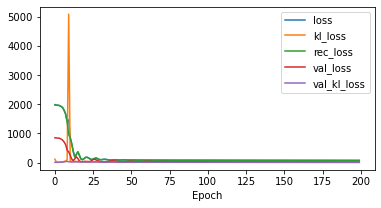

In [65]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

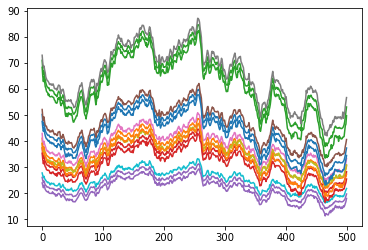

In [66]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

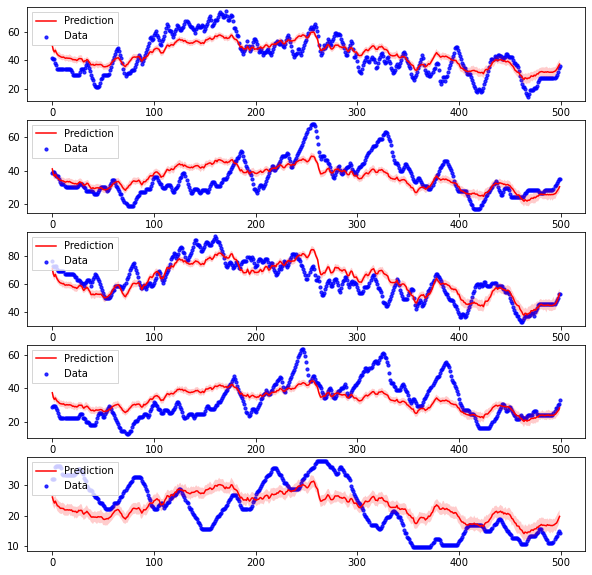

In [67]:
fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [ ]:
####################################################################################################################